## Подключитесь к базе. Загрузите таблицы sql

In [1]:
!pip install imbalanced-learn -q
!pip install phik -q

In [59]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay,\
roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#import psycopg2
#import gc
#
#from sklearn.pipeline import Pipeline
#from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
#from imblearn.over_sampling import SMOTE
#from sklearn.model_selection import GridSearchCV

Конфигурация подключения к базе данных:

In [3]:
db_config = {
    'user': 'praktikum_student',
    'password': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'database': 'data-science-vehicle-db'
}

Создание строки подключения и подключения к базе данных:

In [4]:
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

Проверка наличия таблиц в базе данных:

In [5]:
# Список таблиц, которые нужно проверить
tables_to_check = ['collisions', 'parties', 'vehicles']

Проверка наличия нужных таблиц и вывод информации о их колонках:

In [6]:
for table_name in tables_to_check:
    # Проверка наличия таблицы
    query = f"""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
    AND table_name = '{table_name}';
    """
    result_df = pd.read_sql(query, engine)
    
    if not result_df.empty:
        print(f"\nТаблица '{table_name}' существует в базе данных.\n")
        
        # Получение информации о столбцах таблицы
        query = f"""
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = '{table_name}';
        """
        columns_df = pd.read_sql(query, engine)
        
        # Выводим информацию о столбцах
        print(f"Столбцы таблицы '{table_name}':\n")
        display(columns_df)
    
    else:
        print(f"Таблица '{table_name}' не найдена в базе данных.")


Таблица 'collisions' существует в базе данных.

Столбцы таблицы 'collisions':



,column_name,data_type
0,party_count,integer
1,intersection,integer
2,distance,real
3,collision_date,date
4,collision_time,time without time zone
5,location_type,text
6,collision_damage,text
7,case_id,text
8,pcf_violation_category,text
9,type_of_collision,text



Таблица 'parties' существует в базе данных.

Столбцы таблицы 'parties':



,column_name,data_type
0,cellphone_in_use,integer
1,party_number,integer
2,at_fault,integer
3,insurance_premium,integer
4,id,integer
5,case_id,text
6,party_drug_physical,text
7,party_type,text
8,party_sobriety,text



Таблица 'vehicles' существует в базе данных.

Столбцы таблицы 'vehicles':



,column_name,data_type
0,id,integer
1,party_number,integer
2,vehicle_age,integer
3,case_id,text
4,vehicle_type,text
5,vehicle_transmission,text


In [7]:
for table_name in tables_to_check:
    print(f"\nПервые 10 строк из таблицы '{table_name}':")
    
    # SQL-запрос для получения первых 10 строк
    query = f"SELECT * FROM {table_name} LIMIT 10;"
    
    # Выполнение запроса и присваивание в переменную с динамическим именем
    globals()[f"{table_name}_df"] = pd.read_sql(query, engine)
    
    # Вывод первых 10 строк
    display(globals()[f"{table_name}_df"])

# Закрытие соединения с базой данных
engine.dispose()


Первые 10 строк из таблицы 'collisions':


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00



Первые 10 строк из таблицы 'parties':


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN



Первые 10 строк из таблицы 'vehicles':


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


## Проведите первичное исследование таблиц

In [8]:
# Первичное исследование таблиц
collisions_df.info()
parties_df.info()
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      10 non-null     object 
 1   county_city_location         10 non-null     object 
 2   county_location              10 non-null     object 
 3   distance                     10 non-null     float64
 4   direction                    4 non-null      object 
 5   intersection                 10 non-null     int64  
 6   weather_1                    10 non-null     object 
 7   location_type                5 non-null      object 
 8   collision_damage             10 non-null     object 
 9   party_count                  10 non-null     int64  
 10  primary_collision_factor     10 non-null     object 
 11  pcf_violation_category       9 non-null      object 
 12  type_of_collision            10 non-null     object 
 13  motor_vehicle_involved_

Присутствуют пропуски в нескольких столбцах, особенно в таблицах `collisions` и `parties`.

Столбцы `collision_date` и `collision_time` в таблице `collisions` представлены в виде строк. Для дальнейшей работы с этими данными их можно преобразовать в типы `datetime` и `time` соответственно.

Во всех трех таблицах присутствует общий столбец `case_id`, который, играет роль идентификатора случая ДТП и будет использоваться для объединения данных из разных таблиц.

##  Проведите статистический анализ факторов ДТП

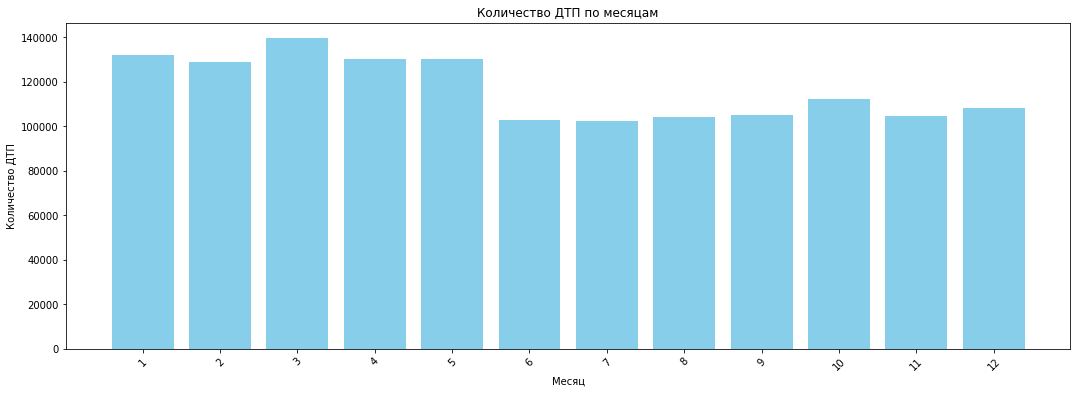

In [9]:
# Статистический анализ факторов ДТП по месяцам
query = """
SELECT EXTRACT(MONTH FROM collision_date) AS month, COUNT(*) AS accident_count
FROM collisions
GROUP BY month
ORDER BY month;
"""
accidents_by_month_df = pd.read_sql(query, engine)

# Построение графика количества ДТП по месяцам
plt.figure(figsize=(18, 6))
plt.bar(accidents_by_month_df['month'], accidents_by_month_df['accident_count'], color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.title('Количество ДТП по месяцам')
plt.xticks(accidents_by_month_df['month'], rotation=45)
plt.show()

Первые 5 месяцев года (с января по май) оказываются самыми аварийными, это может быть связано с несколькими факторами, которые влияют на дорожную обстановку и поведение водителей в этот период:
- Скользкие дороги зимой
- Переходные погодные условия весной
- Рост активности на дорогах ближе к началу отпускного сезона

Видно, что наибольшее количество ДТП приходится на март. Это может быть связано с сочетанием переменчивых погодных условий, активизацией дорожного движения и ухудшением состояния дорог после зимы.

Задачи для аналитиков:

- Проанализируйте серьёзность повреждений транспортных средств в зависимости от состояния дороги.
- Найдите, как погодные условия влияют на количество ДТП.
- Проверьте, есть ли корреляция между возрастом автомобиля и вероятностью его участия в ДТП.
- Изучите зависимость между трезвостью водителя и его участием в ДТП.
- Исследуйте частоту использования мобильных телефонов водителями, причастными к ДТП.
- Найдите самые частые причины ДТП.

Решение двух задач:

Анализ количества ДТП в зависимости от состояния дороги и типа транспортного средства:

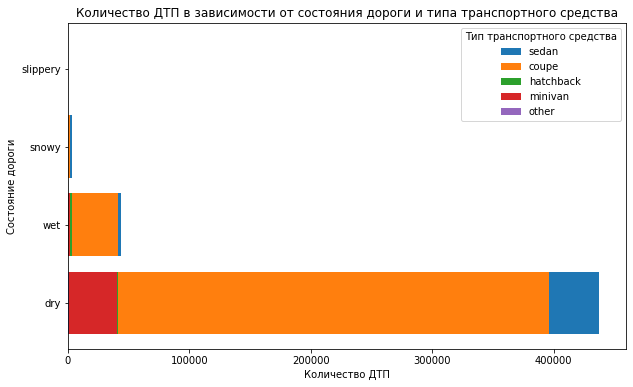

In [10]:
query = """
SELECT c.road_surface, v.vehicle_type, COUNT(*) AS accident_count
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
GROUP BY c.road_surface, v.vehicle_type
ORDER BY accident_count DESC;
"""
road_surface_df = pd.read_sql(query, engine)

# Удалим строки с пропусками
road_surface_df.dropna(subset=['road_surface', 'vehicle_type'], inplace=True)

# Построение графика
plt.figure(figsize=(10, 6))
for vehicle_type in road_surface_df['vehicle_type'].unique():
    df_subset = road_surface_df[road_surface_df['vehicle_type'] == vehicle_type]
    plt.barh(df_subset['road_surface'], df_subset['accident_count'], label=vehicle_type)

plt.xlabel('Количество ДТП')
plt.ylabel('Состояние дороги')
plt.title('Количество ДТП в зависимости от состояния дороги и типа транспортного средства')
plt.legend(title='Тип транспортного средства')
plt.show()

Основная масса ДТП происходит на сухой дороге, что свидетельствует о том, что благоприятные погодные условия не всегда гарантируют безопасность на дороге. Купе чаще попадают в аварии.

Анализ количества ДТП в зависимости от уровня трезвости водителя и тяжести повреждений:

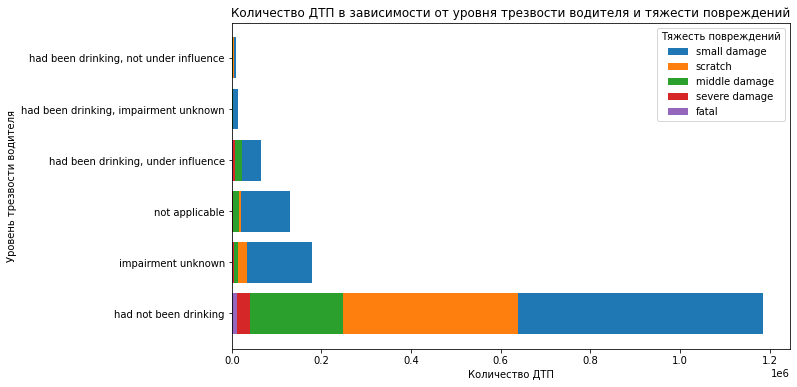

In [11]:
# Анализ зависимости между трезвостью водителя и его участием в ДТП
query = """
SELECT p.party_sobriety, c.collision_damage, COUNT(*) AS accident_count
FROM parties p
JOIN collisions c ON p.case_id = c.case_id
GROUP BY p.party_sobriety, c.collision_damage
ORDER BY accident_count DESC;
"""
sobriety_df = pd.read_sql(query, engine)

# Удалим строки с пропусками
sobriety_df.dropna(subset=['party_sobriety', 'collision_damage'], inplace=True)

# Построение графика
plt.figure(figsize=(10, 6))
for damage_type in sobriety_df['collision_damage'].unique():
    df_subset = sobriety_df[sobriety_df['collision_damage'] == damage_type]
    plt.barh(df_subset['party_sobriety'], df_subset['accident_count'], label=damage_type)

plt.xlabel('Количество ДТП')
plt.ylabel('Уровень трезвости водителя')
plt.title('Количество ДТП в зависимости от уровня трезвости водителя и тяжести повреждений')
plt.legend(title='Тяжесть повреждений')
plt.show()

Большинство ДТП совершают водители, которые не употребляли алкоголь. Это может свидетельствовать о том, что значительное количество аварий происходит из-за других факторов, а не только из-за алкогольного опьянения.

## Создайте модель для оценки водительского риска

In [12]:
# Запрос для получения данных о водителях автомобилей
query = """
SELECT 
    p.at_fault,
    p.party_sobriety, 
    c.collision_date, 
    c.collision_time,
    c.weather_1, 
    c.road_surface, 
    c.lighting, 
    v.vehicle_age, 
    v.vehicle_type, 
    v.vehicle_transmission
FROM 
    parties p
JOIN 
    collisions c ON p.case_id = c.case_id
JOIN 
    vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE 
    p.party_type = 'car'
    AND LOWER(c.collision_damage) != 'scratch'
    AND EXTRACT(YEAR FROM c.collision_date) = 2012;
"""
data_df = pd.read_sql(query, engine)

In [13]:
# Проверка данных
data_df.head()

,at_fault,party_sobriety,collision_date,collision_time,weather_1,road_surface,lighting,vehicle_age,vehicle_type,vehicle_transmission
0,0,had not been drinking,2012-04-29,01:23:00,clear,dry,dark with street lights,NaN,sedan,auto
1,1,had not been drinking,2012-05-03,13:50:00,cloudy,dry,daylight,3.0,sedan,auto
2,0,had not been drinking,2012-04-27,23:31:00,clear,dry,dark with no street lights,2.0,sedan,auto
3,0,had not been drinking,2012-03-24,14:45:00,raining,wet,daylight,4.0,sedan,auto
4,0,had not been drinking,2012-03-07,19:13:00,clear,dry,dark with street lights,2.0,sedan,auto


Проверим наличие пропусков в данных:

In [14]:
data_df.isnull().sum()

at_fault                   0
party_sobriety           872
collision_date             0
collision_time            88
weather_1                168
road_surface             348
lighting                 154
vehicle_age             1694
vehicle_type               0
vehicle_transmission     859
dtype: int64

Заполним медианными значениями пропуски в этих признаках:

In [15]:
data_df['collision_time'] = data_df['collision_time'].fillna(pd.to_datetime(data_df['collision_time'],\
                                                                            format='%H:%M:%S').median().time())

In [16]:
data_df['vehicle_age'] = data_df['vehicle_age'].fillna(data_df['vehicle_age'].median())

Пропуски в данных в следующих признаках можно заполнить самым частым значением:

In [17]:
data_df['party_sobriety'] = data_df['party_sobriety'].fillna(data_df['party_sobriety'].mode()[0])

In [18]:
data_df['weather_1'] = data_df['weather_1'].fillna(data_df['weather_1'].mode()[0])

In [19]:
data_df['road_surface'] = data_df['road_surface'].fillna(data_df['road_surface'].mode()[0])

In [20]:
data_df['lighting'] = data_df['lighting'].fillna(data_df['lighting'].mode()[0])

In [21]:
data_df['vehicle_transmission'] = data_df['vehicle_transmission'].fillna(data_df['vehicle_transmission'].mode()[0])

In [22]:
# Проверка на наличие пропусков после заполнения
data_df.isnull().sum()

at_fault                0
party_sobriety          0
collision_date          0
collision_time          0
weather_1               0
road_surface            0
lighting                0
vehicle_age             0
vehicle_type            0
vehicle_transmission    0
dtype: int64

In [23]:
# Описание числовых признаков
data_df.describe()

# Описание категориальных признаков
data_df.describe(include=['object'])

,party_sobriety,collision_date,collision_time,weather_1,road_surface,lighting,vehicle_type,vehicle_transmission
count,56248,56248,56248,56248,56248,56248,56248,56248
unique,6,366,1435,7,4,5,3,2
top,had not been drinking,2012-03-17,15:00:00,clear,dry,daylight,sedan,manual
freq,49449,571,413,45260,50590,38218,37180,30177


In [24]:
# Преобразование даты 'collision_date'
data_df['collision_month'] = pd.to_datetime(data_df['collision_date']).dt.month
data_df['collision_day'] = pd.to_datetime(data_df['collision_date']).dt.day
data_df['collision_day_of_week'] = pd.to_datetime(data_df['collision_date']).dt.dayofweek

# Преобразование времени 'collision_time'
data_df['collision_hour'] = pd.to_datetime(data_df['collision_time'], format='%H:%M:%S').dt.hour

# Удаляем исходные столбцы с датой и временем, так как они больше не нужны
data_df = data_df.drop(['collision_date', 'collision_time'], axis=1)

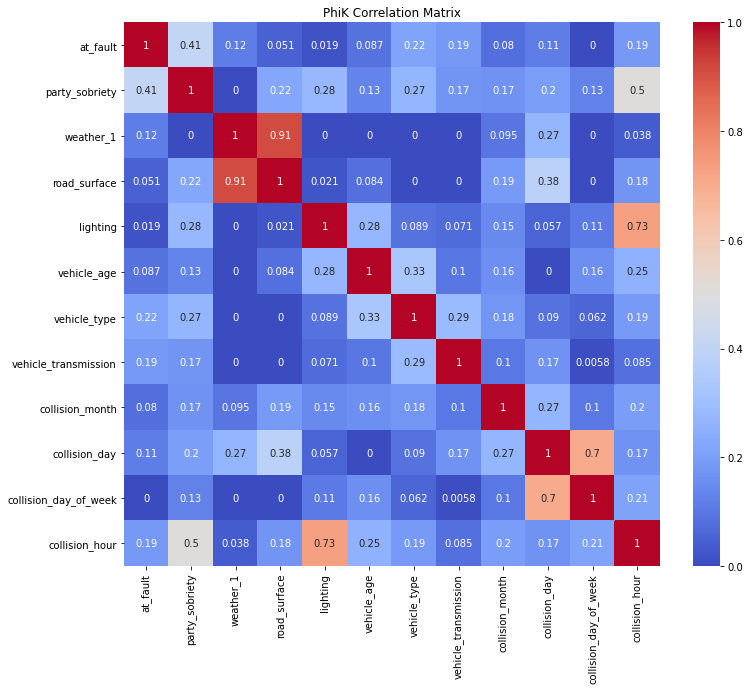

In [25]:
# Преобразуем категориальные признаки в числовые (если это необходимо)
# Например, используя LabelEncoder или get_dummies (One-Hot Encoding)
# Возьмем случайную выборку из данных
sample_df = data_df.sample(n=1000, random_state=42)

# Вычислим корреляционную матрицу PhiK
phik_matrix = sample_df.phik_matrix(interval_cols=[])

# Отобразим матрицу корреляции с помощью heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('PhiK Correlation Matrix')
plt.show()

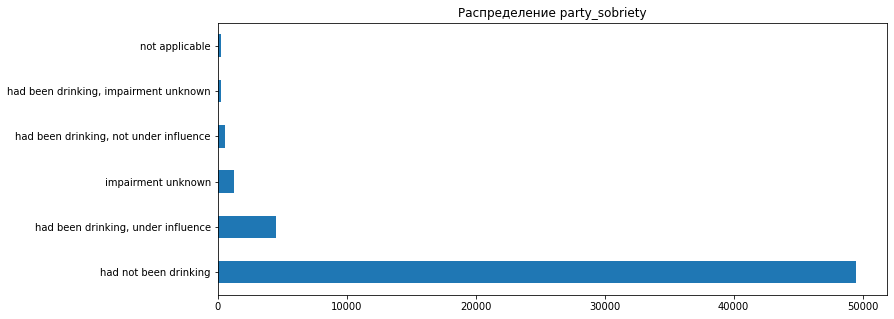

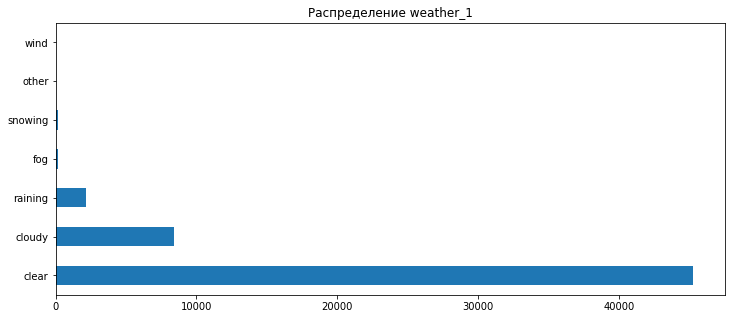

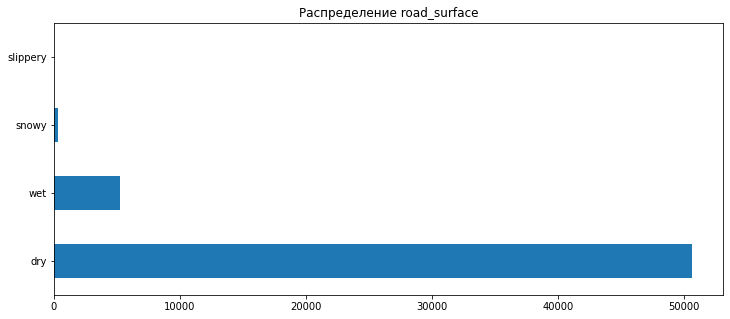

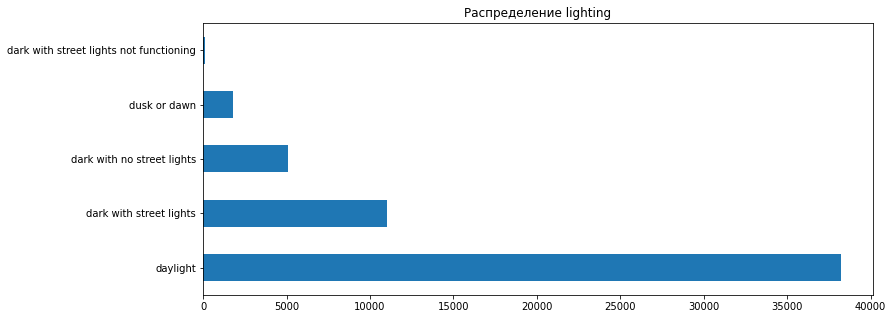

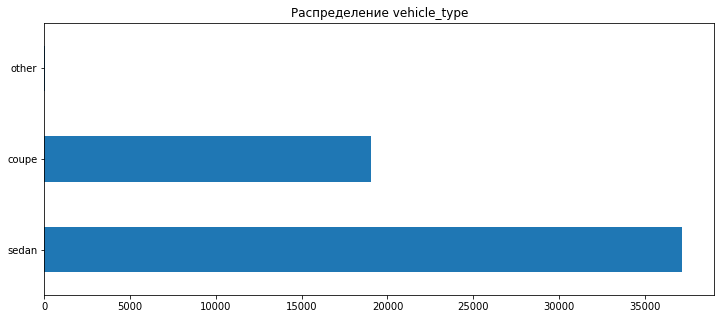

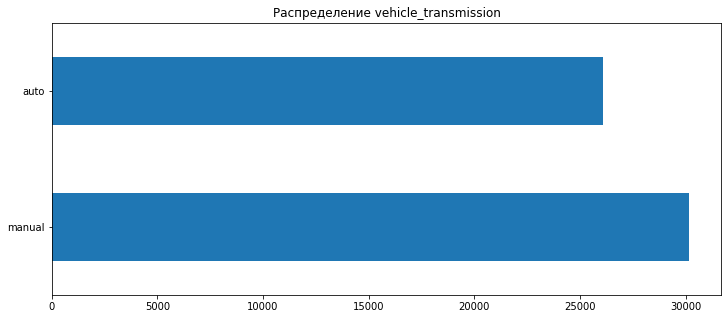

In [26]:
# Столбчатые диаграммы для категориальных признаков
for column in ['party_sobriety', 'weather_1', 'road_surface', 'lighting', 'vehicle_type', 'vehicle_transmission']:
    data_df[column].value_counts().plot(kind='barh', figsize=(12, 5))
    plt.title(f'Распределение {column}')
    plt.show()

Наблюдаемый на графиках сильный дисбаланс классов может привести к искажению результатов анализа и снижению точности моделей, обученных на этих данных.

In [28]:
# Определение X и y
X = data_df[['party_sobriety', 'collision_month', 'collision_day', 'collision_day_of_week', 'collision_hour', 'weather_1', 'road_surface', 'lighting', 'vehicle_age',\
            'vehicle_type', 'vehicle_transmission']]
y = data_df['at_fault']  # Целевая переменная

In [29]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

In [30]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
categorical_features = ['party_sobriety', 'weather_1', 'road_surface', 'lighting', 'vehicle_type', 'vehicle_transmission']
numerical_features = ['vehicle_age', 'collision_month', 'collision_day', 'collision_day_of_week', 'collision_hour']

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),  # Кодирование категориальных признаков
        ('num', SimpleImputer(strategy='mean'), numerical_features)  # Импутация пропусков для числовых данных
    ], remainder='passthrough'  # Остальные столбцы пропускаем без изменений
)

In [34]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Если классы сильно несбалансированы, PR AUC будет полезна для оценки модели, так как она фокусируется на положительном классе (высокий риск ДТП).

Logistic Regression PR AUC (Test Set): 0.7117098107932662
Logistic Regression Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.59      0.75      0.66      8350
           1       0.67      0.48      0.56      8525

    accuracy                           0.62     16875
   macro avg       0.63      0.62      0.61     16875
weighted avg       0.63      0.62      0.61     16875



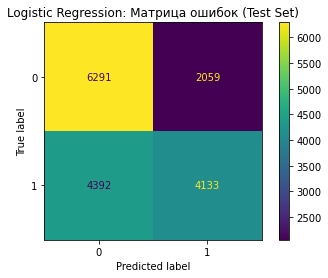

In [51]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)) #Increased max_iter

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Make predictions
y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = pipe.predict(X_test)

# Evaluate the model
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision) #Correct calculation
print(f"Logistic Regression PR AUC (Test Set): {pr_auc}")
print("Logistic Regression Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Logistic Regression: Матрица ошибок (Test Set)')
plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры для Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}
Средний AUC на кросс-валидации: 0.6844914981468476
Random Forest Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.59      0.77      0.67      8350
           1       0.68      0.48      0.56      8525

    accuracy                           0.62     16875
   macro avg       0.64      0.63      0.62     16875
weighted avg       0.64      0.62      0.62     16875

PR AUC (Test Set): 0.7205611901813043


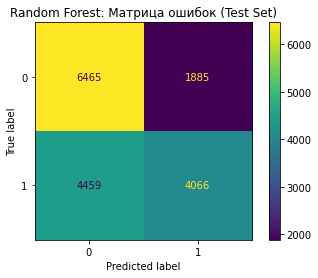

In [44]:
# Оптимизация гиперпараметров для Random Forest
param_dist_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# RandomizedSearchCV для оптимизации гиперпараметров
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf,
                                      n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

# Лучшая модель и её гиперпараметры
best_rf = random_search_rf.best_estimator_
print(f"Лучшие параметры для Random Forest: {random_search_rf.best_params_}")

# Кросс-валидация по лучшей модели
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Средний AUC на кросс-валидации: {np.mean(cv_scores)}")

# Оценка на тестовой выборке
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Метрики для тестовой выборки
print("Random Forest Classification Report (Test Set):")
print(classification_report(y_test, y_pred_rf))

# PR AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
pr_auc = auc(recall, precision)
print(f"PR AUC (Test Set): {pr_auc}")

# Матрица ошибок для Random Forest на тестовой выборке
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(conf_matrix_rf).plot()
plt.title('Random Forest: Матрица ошибок (Test Set)')
plt.show()



Gradient Boosting Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.60      0.75      0.67      8350
           1       0.68      0.51      0.59      8525

    accuracy                           0.63     16875
   macro avg       0.64      0.63      0.63     16875
weighted avg       0.64      0.63      0.63     16875



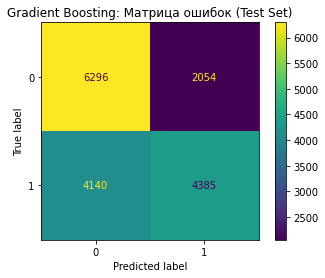

Gradient Boosting PR AUC (Test Set): 0.7251136246489926


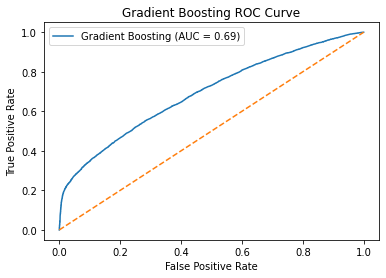

In [62]:
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_pipeline.fit(X_train, y_train)

gb_y_proba = gb_pipeline.predict_proba(X_test)[:, 1]
gb_y_pred = gb_pipeline.predict(X_test)

def evaluate_model(model_name, y_true, y_pred, y_proba):
    print(f"\n{model_name} Classification Report (Test Set):")
    print(classification_report(y_true, y_pred))

    conf_matrix = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(conf_matrix).plot()
    plt.title(f'{model_name}: Матрица ошибок (Test Set)')
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    print(f"{model_name} PR AUC (Test Set): {pr_auc}")

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

evaluate_model("Gradient Boosting", y_test, gb_y_pred, gb_y_proba)

## Проведите анализ важности факторов ДТП

Статистическая сводка для числовых признаков:

In [ ]:
data_df.describe()

Данные достаточно сбалансированы.

Анализ категориальных признаков:

In [ ]:
# Распределение трезвости водителя
data_df['party_sobriety'].value_counts().plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Распределение трезвости водителя')
plt.xlabel('Трезвость')
plt.ylabel('Количество')
plt.show()

# Распределение погодных условий
data_df['weather_1'].value_counts().plot(kind='bar', color='lightgreen', figsize=(10, 6))
plt.title('Распределение погодных условий')
plt.xlabel('Погодные условия')
plt.ylabel('Количество')
plt.show()

Большая часть записей в выборке - трезвые водители и ясная погода.

Корреляция между возрастом автомобиля и участием в ДТП:

In [ ]:
# Визуализация распределения возраста автомобилей в зависимости от виновности
plt.figure(figsize=(10, 6))
data_df.boxplot(column='vehicle_age', by='at_fault')
plt.title('Возраст автомобиля в зависимости от виновности в ДТП')
plt.suptitle('')
plt.xlabel('Виновность')
plt.ylabel('Возраст автомобиля')
plt.show()

Возраст автомобиля не дает явных выводов относительно виновности.

Влияние погодных условий на вероятность ДТП:

In [ ]:
# Группировка данных по погодным условиям и виновности
weather_fault_df = data_df.groupby(['weather_1', 'at_fault']).size().unstack()

# Построение графика
weather_fault_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'salmon'])
plt.title('Влияние погодных условий на вероятность участия в ДТП')
plt.xlabel('Погодные условия')
plt.ylabel('Количество ДТП')
plt.show()

Погодные условия мало влияют на возникновение аварии.

In [ ]:
# 1. Получение коэффициентов логистической регрессии
coef_log = log_model.coef_[0]  # Коэффициенты для первой (и единственной) целевой переменной
abs_coef_log = np.abs(coef_log)  # Берем абсолютные значения коэффициентов

# 2. Преобразуем кодированные имена признаков для логистической регрессии, как и для Random Forest
feature_names_log = encoder.get_feature_names_out(input_features=X.columns)

# 3. Важность признаков для Logistic Regression
plt.figure(figsize=(10, 6))
plt.barh(feature_names_log, abs_coef_log, color='salmon')
plt.xlabel('Абсолютное значение коэффициента')
plt.title('Logistic Regression: Важность признаков')
plt.show()

# Анализ важности признаков для Random Forest
importances_rf = rf_model.feature_importances_
feature_names = encoder.get_feature_names_out(input_features=X.columns)

# Важность признаков для Random Forest
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances_rf, color='skyblue')
plt.xlabel('Важность признака')
plt.title('Random Forest: Важность признаков')
plt.show()

# Анализ важности признаков для Gradient Boosting
importances_gb = gb_model.feature_importances_

# Важность признаков для Gradient Boosting
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances_gb, color='lightgreen')
plt.xlabel('Важность признака')
plt.title('Gradient Boosting: Важность признаков')
plt.show()

Наиболее значимыми фактором для увеличения вероятности ДТП является состояние алкогольного опьянения водителя.

Зависимость между одним из важных признаков модели и целевым признаком:

In [ ]:
# Группировка данных по уровню трезвости и виновности
sobriety_fault_df = data_df.groupby(['party_sobriety', 'at_fault']).size().unstack()

# Построение графика
sobriety_fault_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'salmon'])
plt.title('Зависимость между трезвостью водителя и виновностью в ДТП')
plt.xlabel('Уровень трезвости водителя')
plt.ylabel('Количество ДТП')
plt.legend(['Не виновен', 'Виновен'])
plt.show()

Большинство нетрезвых водителей попало в аварию.

Предложения по оснащению автомобиля на основе анализа зависимости между уровнем трезвости водителя и его виновностью в ДТП:

- Алкотестер: Чтобы снизить риск ДТП, автомобили можно оснастить алкотестерами, которые будут проверять уровень алкоголя в организме водителя перед началом поездки. Водитель сможет завести машину только после тестирования, если уровень алкоголя в пределах допустимого.



- Камеры с распознаванием лица: Для того чтобы убедиться, что тест на алкоголь проходит именно водитель, можно установить камеру с функцией распознавания лиц. Это позволит не допустить мошенничество, когда тест может пройти другой человек вместо водителя.

## Выводы

Лучшей моделью оказалась Logistic Regression. Создание адекватной системы оценки риска при выдаче авто возможно. При выдаче авто необходимо проверять уровень трезвости водителя.